In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def readAndPreprocess(img_path):
    # Read and convert from BGR to RGB
    img = cv2.imread(img_path)[..., ::-1]
    # Resize
    img = cv2.resize(img, (224, 224))
    # Convert to tensor, normalize and flatten 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # From ImageNet 
    ])
    img = transform(img).unsqueeze_(0)
    return img

In [ ]:
readAndPreprocess("../images/lena.png")

tensor([[[[ 1.7523,  1.7009,  1.7523,  ...,  1.7865,  1.8893,  1.5297],
          [ 1.7523,  1.7009,  1.7523,  ...,  1.7865,  1.8893,  1.5297],
          [ 1.7694,  1.7009,  1.7865,  ...,  1.4954,  1.2385,  0.4337],
          ...,
          [-0.6109, -0.5082, -0.4568,  ...,  0.1254,  0.4508,  0.6221],
          [-0.6452, -0.5596, -0.4911,  ...,  0.3652,  0.7933,  0.7419],
          [-0.7137, -0.5253, -0.5253,  ...,  0.6221,  0.9132,  0.9988]],

         [[ 0.3627,  0.3452,  0.2577,  ...,  0.4678,  0.5728,  0.0476],
          [ 0.3627,  0.3452,  0.2577,  ...,  0.4678,  0.5728,  0.0476],
          [ 0.3803,  0.2577,  0.2927,  ..., -0.0224, -0.3025, -1.0378],
          ...,
          [-1.5980, -1.5105, -1.5280,  ..., -1.2829, -0.8803, -1.0028],
          [-1.6331, -1.5805, -1.6331,  ..., -1.0028, -0.8452, -0.8978],
          [-1.6506, -1.5455, -1.6506,  ..., -0.8627, -0.8803, -0.7752]],

         [[ 0.3742,  0.4265,  0.2348,  ...,  0.4439,  0.3393, -0.0092],
          [ 0.3742,  0.4265,  

In [ ]:
def forward_img(model, x, layer_max_count):
    deconv_layers_list = []
    unpool_layers_list = []

    layer_count = 0

    for layer in model.features:
        if isinstance(layer, torch.nn.Conv2d):
            B, C, H, W = x.shape
            x = layer(x)
            deconv_layer = nn.ConvTranspose2d(layer.out_channels, C, layer.kernel_size, layer.stride, layer.padding)
            deconv_layer.weight = layer.weight
            deconv_layers_list.append(deconv_layer)

        if isinstance(layer, torch.nn.ReLU):
            x = layer(x)
            deconv_layers_list.append(layer)

        if isinstance(layer, torch.nn.MaxPool2d):
            x, index = layer(x)
            unpool_layers_list.append(index)
            unpool_layer = torch.nn.MaxUnpool2d(kernel_size=layer.kernel_size, stride=layer.stride,
                                                padding=layer.padding)
            deconv_layers_list.append(unpool_layer)

        layer_count += 1
        if layer_max_count == layer_count:
            break

    return x, deconv_layers_list, unpool_layers_list

In [ ]:
def getDeconvModel(model, input_img, last_layer_index):
    
    layer_list = []
    unpool_indices_list = []

    x = input_img

    for idx, layer in enumerate(model.features):

        if isinstance(layer, torch.nn.Conv2d):
            B, C, H, W = x.shape
            x = layer(x)
            deconv_layer = nn.ConvTranspose2d(layer.out_channels, C, layer.kernel_size, layer.stride, layer.padding)
            deconv_layer.weight = layer.weight
            layer_list.append(deconv_layer)

        if isinstance(layer, torch.nn.ReLU):
            x = layer(x)
            layer_list.append(layer)

        if isinstance(layer, torch.nn.MaxPool2d):
            x, unpool_index = layer(x)
            unpool_indices_list.append(unpool_index)
            unpool_layer = torch.nn.MaxUnpool2d(kernel_size=layer.kernel_size, stride=layer.stride,
                                                padding=layer.padding)
            layer_list.append(unpool_layer)

        if idx + 1 == last_layer_index:
            break

    def deconvNet(y):
        for layer in reversed(layer_list):
            if isinstance(layer, nn.MaxUnpool2d):
                y = layer(y, unpool_indices_list.pop())
            else:
                y = layer(y)
        return y

    return x, deconvNet


In [ ]:
def backward_feature_maps(y, deconv_layers_list, unpool_layers_list):
    for layer in reversed(deconv_layers_list):
        if isinstance(layer, nn.MaxUnpool2d):
            y = layer(y, unpool_layers_list.pop())
        else:
            y = layer(y)

    return y

In [ ]:
model = models.vgg16(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
input_img = readAndPreprocess("../images/lena.png")
#y = model(input_img)
# x, layer_list, unpool_indices_list = getDeconvModel(model, input_img, 4)
# reproducted_img = backward_feature_maps(x, layer_list, unpool_indices_list)
y, deconvNet = getDeconvModel(model, input_img, 4)
reproducted_img = deconvNet(y)

In [ ]:
model(input_img)

tensor([[-1.4810e+00, -1.8858e+00, -1.5064e+00, -9.8444e-01, -2.3639e+00,
          1.2080e-02,  1.7484e-01,  1.2187e+00, -1.5965e+00, -2.5205e+00,
         -3.1932e+00, -4.0576e+00, -1.5255e+00, -2.5088e+00, -1.7782e+00,
         -1.5732e+00, -2.8270e+00, -2.0323e+00, -2.3394e+00, -9.2519e-01,
         -3.2152e+00, -4.3236e+00, -1.6564e+00, -2.2123e+00,  3.6722e-01,
         -2.5015e+00, -9.7769e-01, -7.9982e-01, -4.9361e-01,  1.1516e+00,
         -2.6585e+00, -2.5515e+00, -1.1488e+00, -1.2133e+00,  8.0951e-01,
         -7.9132e-01,  7.5953e-01,  1.4409e-01, -1.7670e+00, -1.1394e-02,
         -3.7935e-01,  6.2355e-01, -4.1788e-01,  2.8538e+00,  1.2578e+00,
         -7.7078e-01, -1.1922e+00,  3.0304e-01, -4.6425e-01, -1.5995e+00,
          1.0832e+00,  1.7228e+00,  5.3949e-01, -1.4764e+00,  1.7675e-02,
         -3.2210e+00, -1.6882e+00, -1.8331e+00, -3.7908e+00, -1.6136e+00,
          3.7552e-01,  1.2594e+00, -1.6370e+00, -1.7803e+00, -3.0065e+00,
         -2.7776e+00, -1.7287e+00, -1.

In [ ]:
def getImg(img):
    npimg = img[0].data.numpy()
    npimg = ((npimg - npimg.min()) * 255 / (npimg.max() - npimg.min())).astype('uint8')
    npimg = np.transpose(npimg, (1, 2, 0))

    # plt.imshow(npimg)
    return npimg


In [ ]:
input_img = readAndPreprocess("../images/lena.png")

model = models.vgg16(pretrained=True).eval()

model(input_img)
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)
layerImgs = {}
for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    # raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
    # reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
    y, deconvNet = getDeconvModel(model, input_img, layer_max_count)
    reproducted_img = deconvNet(y)
    layerImgs[layer_max_count] = getImg(reproducted_img)

# print(layerImgs)

layer...4
layer...9
layer...16
layer...23
layer...30


In [ ]:
cur = input_img

for i, layer in enumerate(model.features):
    try: 
        if i == 5:
            print(cur[1] == cur[0])
            for j in cur: print (type(j))
        cur = layer(cur)
    except Exception as e:
        print("Failed at layer ", i)
        print(e)
        break



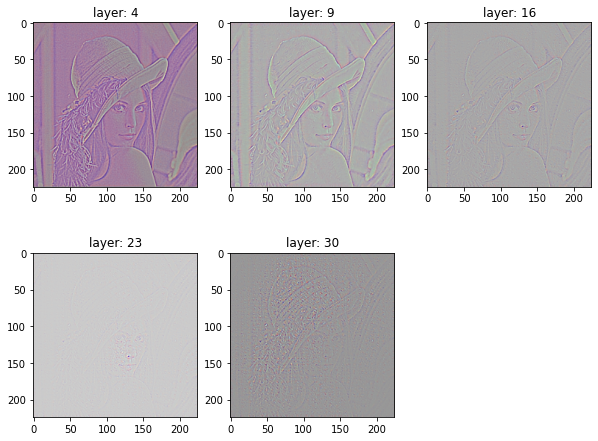

In [ ]:
fig = plt.figure(figsize=(10, 12))
cnt = 1
for key in layerImgs:
    fig.add_subplot(3, 3, cnt)
    cnt += 1
    plt.title('layer: ' + str(key))
    plt.imshow(layerImgs[key])
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=23215390-a215-40e9-a528-0c56ffa0c518' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>